# How The Fuck do We move in a Circle? [Part 1]

In [1]:
%pylab inline
import sys
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sys.path.append('src')
from motorControl import *
from trajectoryPlanning import *
from util import *

## Load Absolute Home, Upper right corner, out of the way, aligned with sharpie marks
f = open('savedPositions/absolute/home.p', 'r')
home = pickle.load(f)
f.close()

In [3]:
rc = connect(portName = "/dev/tty.usbserial-A9ETDN3N")
rc.Open()

1

### Initialized Motor Classes

- Really important to initialze these first to restore positions from last session!

In [92]:
#Initialize motor objects for each motor:
vL = Motor(address = 0x81, motorNumber = 2, rc = rc, signFlipped = True, \
           motorCounter = 0, kPID = [1e-2, 1.0])
vR = Motor(address = 0x81, motorNumber = 1, rc = rc, signFlipped = True, \
           motorCounter = 1, kPID = [1e-2, 1.0])
LR = Motor(address = 0x80, motorNumber = 1, rc = rc, signFlipped = True, 
           motorCounter = 2, kPID = [1e-2, 1.0])
FB = Motor(address = 0x80, motorNumber = 2, rc = rc, signFlipped = False, \
           motorCounter = 3, kPID = [1e-2, 1.0])
yaw = Motor(address = 0x82, motorNumber = 2, rc = rc, signFlipped = True, \
            motorCounter = 4, kPID = [1e-2, 1.0])
pitch = Motor(address = 0x82, motorNumber = 1, rc = rc, signFlipped = True, \
              motorCounter = 5, kPID = [1e-2, 1.0])

#Keep in a nice motor list:
motors = [vL, vR, LR, FB, yaw, pitch]

In [93]:
getPositions(motors)

[-66949, 66942, 49530, -48628, -98226, -62180]

In [94]:
home

[-1047, -2826, 0, 0, 0, -2]

In [136]:
MC = ManualControl(rc)
interact(MC.manualControl, leftUD = (-50, 50), rightUD = (-50, 50), leftRight = (-127, 127), \
         fB = (-127, 127), tilt= (-50, 50), pan = (-50, 50))

<function ipywidgets.widgets.interaction.<lambda>>

In [134]:
stopAll(rc)
savePositions(motors)
getPositions(motors)

[-66949, 66942, -2154, -25825, -66422, -62180]

Let's Start by collecting some real data.

In [137]:
# delta = np.array(getPositions(motors))-np.array(home)
# f = open('savedPositions/relative/UNCCV1/B.p', 'wb')
# pickle.dump(delta, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

In [138]:
#Position A
f = open('savedPositions/relative/UNCCV1/A.p', 'r')
A = pickle.load(f)+np.array(home) #Return to absolute coords
f.close()

#Position B
f = open('savedPositions/relative/UNCCV1/B.p', 'r')
B = pickle.load(f)+np.array(home) #Return to absolute coords
f.close()

In [28]:
A

array([-66949,  66942,  49674, -48630, -97854, -62145])

In [29]:
B

array([-66949,  66942,  -2884,  11201, -65758, -62180])

Ok, I accidentally canged tilt, **crap**

In [31]:
#motors = [vL, vR, LR, FB, yaw, pitch]
A-B

array([     0,      0,  52558, -59831, -32096,     35])

Ok, cool. I think I can path plan this! So, the trick, I think is normalizing my x and y values to reach pi over 2 at the endpoint?

I guess the angle is really going to "drive the whole show" since it varies linearly with time.

And I guess really it's a function of time...ok...

In [34]:
A[4]

-97854

In [40]:
B[4]

-65758

-65758

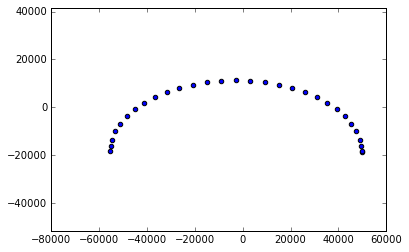

In [87]:
#Let's consider a semi circle

total_time = 30.0 #seconds
ramp_time = 3.0

initial_pan = A[4]
final_pan = A[4] + 2*(B[4]-A[4])
initial_lr = A[2]
final_lr = A[2] + 2*(B[2]-A[2])
initial_fb = A[3]
max_fb = B[3]

## Ok, here's a crazy idea, can i use my quadratic trajectory for angle, 
## and use this to drive the others? That could be cool....

panTrajectory = SimpleQuadraticTrajectory(tu = ramp_time, tt = total_time, p1 = initial_pan, p2 = final_pan)

# Now I think I need to make my trajectory into angles (in radian of course)
for t in range(30):
    pan = panTrajectory.compute(t)
    current_angle = np.pi*(pan-initial_pan)/(final_pan-initial_pan)

    current_lr = (-(final_lr-initial_lr)/2.0)*cos(current_angle) + (final_lr+initial_lr)/2.0
    current_fb = ((max_fb-initial_fb)/2.0)*sin(current_angle) + (max_fb+initial_fb)/2.0
    scatter(current_lr, current_fb)
    
axis('equal');

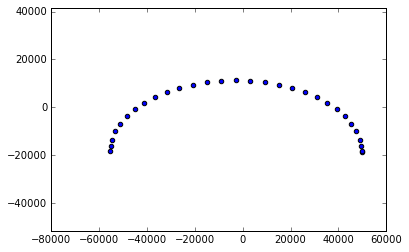

In [67]:
#Let's consider a semi circle

total_time = 30.0 #seconds
ramp_time = 3.0

initial_pan = A[4]
final_pan = A[4] + 2*(B[4]-A[4])
initial_lr = A[2]
final_lr = A[2] + 2*(B[2]-A[2])
initial_fb = A[3]
max_fb = B[3]

## Ok, here's a crazy idea, can i use my quadratic trajectory for angle, 
## and use this to drive the others? That could be cool....

panTrajectory = SimpleQuadraticTrajectory(tu = ramp_time, tt = total_time, p1 = initial_pan, p2 = final_pan)

# Now I think I need to make my trajectory into angles (in radian of course)
for t in range(30):
    pan = panTrajectory.compute(t)
    current_angle = np.pi*(pan-initial_pan)/(final_pan-initial_pan)

    current_lr = (-(final_lr-initial_lr)/2.0)*cos(current_angle) + (final_lr+initial_lr)/2.0
    current_fb = ((max_fb-initial_fb)/2.0)*sin(current_angle) + (max_fb+initial_fb)/2.0
    scatter(current_lr, current_fb)
    
axis('equal');

In [153]:
#Let's consider a semi circle

total_time = 60.0 #seconds
ramp_time = 3.0

initial_pan = A[4]
final_pan = A[4] + 2*(B[4]-A[4])
initial_lr = A[2]
final_lr = A[2] + 2*(B[2]-A[2])
initial_fb = A[3]
max_fb = B[3]

## Ok, here's a crazy idea, can i use my quadratic trajectory for angle, 
## and use this to drive the others? That could be cool....

panTrajectory = SimpleQuadraticTrajectory(tu = ramp_time, tt = total_time, p1 = initial_pan, p2 = final_pan)

motorsToMove = [LR, FB, yaw]

In [154]:
for motor in motorsToMove:
    motor.initialize(targetVelocityMin = -10000.0, targetVelocityMax = 10000.0)
    motor.clearTracking()
    
startTime = time.time()
timeElapsed = 0.0
    
while timeElapsed < total_time:
    timeElapsed = time.time()-startTime

    pan = panTrajectory.compute(timeElapsed + lookAheadTime)
    current_angle = np.pi*(pan-initial_pan)/(final_pan-initial_pan)

    current_lr = (-(final_lr-initial_lr)/2.0)*cos(current_angle) + (final_lr+initial_lr)/2.0
    current_fb = (max_fb-initial_fb)*sin(current_angle) + initial_fb

    motorsToMove[0].controlledMove(targetPosition = current_lr, timeToReach = lookAheadTime)
    motorsToMove[1].controlledMove(targetPosition = current_fb, timeToReach = lookAheadTime)
    motorsToMove[2].controlledMove(targetPosition = pan, timeToReach = lookAheadTime)

    
stopAll(rc)
savePositions(motors)

voltage too low on motor 3
excess voltage on motor 3
excess voltage on motor 3


In [118]:
stopAll(rc)
savePositions(motors)

Cool!

## Move the rig

In [155]:
targetPositions = A
totalTime = 55.0
rampTime = 1.0

startingPositions = getPositions(motors)
lookAheadTime = 1.0
tolerance = 100.0 #Anything less than this many ticks we're calling "Not a move"

motorsToMove = []
targetPositionsToMove = []
for i, motor in enumerate(motors):
    if abs(motor.getPosition()-targetPositions[i]) > tolerance:
        motorsToMove.append(motor)
        targetPositionsToMove.append(targetPositions[i])
        
trajectories = []
for i, motor in enumerate(motorsToMove):
    trajectories.append(SimpleQuadraticTrajectory(tu = rampTime, tt = totalTime, \
                                            p1 = motor.getPosition(), p2 = targetPositionsToMove[i]))
    
print np.array(targetPositions) - startingPositions
print 'Planning to move ' +  str(len(motorsToMove)) + ' motors.'

[     0      0 110901   -390 -64791      0]
Planning to move 3 motors.


In [156]:
for motor in motorsToMove:
    motor.initialize(targetVelocityMin = -25000.0, targetVelocityMax = 25000.0)
    motor.clearTracking()
    
startTime = time.time()
timeElapsed = 0.0
    
while timeElapsed < totalTime:
    timeElapsed = time.time()-startTime
    
    for i, motor in enumerate(motorsToMove):
        lookAheadValue = trajectories[i].compute(timeElapsed + lookAheadTime)
        motor.controlledMove(targetPosition = lookAheadValue, timeToReach = lookAheadTime)

stopAll(rc)
savePositions(motors)
print getPositions(motors), targetPositions
print getPositions(motors) - np.array(targetPositions)

voltage too low on motor 4
excess voltage on motor 4
excess voltage on motor 4
excess voltage on motor 2
voltage too low on motor 2
voltage too low on motor 2
[-66949, 66942, 50559, -85112, -97987, -62180] [-66949  66942  51146 -85118 -98328 -62180]
[   0    0 -587    6  341    0]


In [30]:
stopAll(rc)
savePositions(motors)

In [ ]:
A

In [ ]:
getPositions(motors)